<a href="https://colab.research.google.com/github/dustinak80/Deep_Learning/blob/master/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 - Stock price prediction

---



## Import packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant

## Import the Data

In [0]:
stocks = pd.read_csv('https://raw.githubusercontent.com/dustinak80/Deep_Learning/master/HW3/stocks_dataset.csv')

In [0]:
stocks.tail()

,Date,ABT,ABBV,ABMD,A,ALXN,ALGN,AGN,ABC,AMGN,ANTM,BAX,BDX,BIIB,BSX,BMY,CAH,CNC,CERN,CI,COO,CVS,DHR,DVA,XRAY,EW,GILD,HCA,HSIC,HOLX,HUM,IDXX,ILMN,INCY,ISRG,IQV,JNJ,LH,LLY,MCK,MDT,MRK,MTD,MYL,PKI,PRGO,PFE,DGX,REGN,RMD,STE
1332,2020-04-20 00:00:00,98.000000,83.989998,166.199997,77.370003,106.720001,196.710007,187.389999,89.620003,236.600006,263.200012,94.139999,263.440002,339.410004,37.250000,61.680000,50.740002,68.419998,70.250000,188.699997,304.700012,62.340000,155.830002,77.519997,41.279999,224.600006,81.260002,110.430000,53.150002,43.240002,367.329987,267.339996,322.880005,101.190002,518.330017,127.510002,151.669998,145.610001,157.789993,140.490005,101.540001,83.099998,707.630005,15.86,84.519997,50.860001,36.080002,95.029999,567.989990,164.279999,157.449997
1333,2020-04-21 00:00:00,94.050003,80.360001,164.500000,73.750000,103.389999,187.259995,184.039993,85.570000,230.750000,249.369995,90.099998,256.500000,329.010010,35.049999,60.590000,48.270000,66.239998,68.589996,177.910004,288.529999,60.250000,153.750000,72.529999,39.660000,216.020004,78.529999,105.470001,52.029999,42.349998,358.859985,259.230011,310.399994,99.459999,496.630005,122.000000,149.679993,148.179993,152.669998,132.440002,97.610001,78.559998,683.429993,15.13,82.639999,49.689999,35.619999,94.459999,544.460022,157.350006,147.779999
1334,2020-04-22 00:00:00,95.480003,81.470001,166.729996,75.169998,103.910004,190.029999,185.339996,86.500000,229.289993,262.959992,90.540001,266.760010,298.010010,35.490002,60.930000,49.040001,68.349998,70.779999,182.589996,294.100006,60.349998,160.250000,72.410004,39.910000,216.520004,81.309998,104.519997,51.709999,42.880001,367.170013,268.119995,311.559998,100.970001,512.130005,125.550003,152.990005,154.130005,156.710007,135.220001,96.080002,79.980003,704.200012,14.91,85.550003,49.619999,36.250000,99.580002,558.080017,160.919998,150.880005
1335,2020-04-23 00:00:00,93.940002,82.040001,170.759995,75.089996,104.139999,188.570007,185.550003,87.260002,232.490006,261.549988,91.320000,265.079987,292.250000,36.400002,60.950001,49.320000,69.239998,71.150002,184.279999,290.269989,61.279999,160.649994,73.349998,38.700001,221.039993,77.779999,104.739998,51.630001,45.380001,366.070007,268.410004,312.709992,101.900002,513.219971,127.669998,155.509995,159.669998,159.929993,136.570007,95.830002,80.879997,703.299988,15.30,87.199997,50.990002,36.689999,100.660004,565.520019,158.729996,149.449997
1336,2020-04-24 00:00:00,94.059998,83.589996,168.520004,75.750000,108.120003,191.970001,186.899994,88.699997,236.279999,264.119995,92.919998,268.170013,297.799988,36.900002,62.250000,50.320000,70.580002,72.750000,188.199997,293.209992,62.310001,165.070007,74.000000,39.310001,223.479996,79.639999,107.830002,52.389999,47.110001,369.089996,271.799988,309.070007,103.480003,514.929993,128.860001,154.860001,163.720001,162.929993,139.940002,99.300003,81.430000,713.380005,15.76,87.550003,51.430000,37.380001,106.620003,566.210022,161.000000,147.820007


## Data Exploration


In [0]:
# show nice table in colab
%load_ext google.colab.data_table 
from google.colab import data_table

In [6]:
data_table.DataTable(stocks, include_index=False, num_rows_per_page=5)

,Date,ABT,ABBV,ABMD,A,ALXN,ALGN,AGN,ABC,AMGN,ANTM,BAX,BDX,BIIB,BSX,BMY,CAH,CNC,CERN,CI,COO,CVS,DHR,DVA,XRAY,EW,GILD,HCA,HSIC,HOLX,HUM,IDXX,ILMN,INCY,ISRG,IQV,JNJ,LH,LLY,MCK,MDT,MRK,MTD,MYL,PKI,PRGO,PFE,DGX,REGN,RMD,STE
0,2015-01-02 00:00:00,44.900002,65.889999,37.310001,40.560001,186.600006,56.200001,259.130005,90.459999,159.889999,125.459999,39.820751,139.860001,342.010010,13.220000,59.509998,80.510002,26.110001,65.029999,102.830002,160.610001,95.099998,64.988625,75.830002,51.930000,63.860001,94.910004,73.970001,53.662746,26.379999,142.990005,73.665001,185.419998,73.760002,175.190002,59.110001,104.519997,111.419998,70.059998,207.199997,71.879997,57.189999,301.950012,56.349998,44.090000,166.630005,31.330000,68.970001,410.160004,57.169998,65.160004
1,2015-01-05 00:00:00,44.910000,64.650002,37.070000,39.799999,182.169998,56.990002,256.690002,89.690002,157.990005,123.260002,38.832157,140.720001,336.739990,13.810000,58.580002,80.050003,26.040001,64.169998,101.059998,159.369995,94.160004,64.344200,74.699997,51.570000,63.889999,96.790001,71.809998,53.180393,26.120001,139.199997,73.154999,190.720001,74.220001,171.456665,58.410000,103.790001,112.389999,69.370003,208.899994,71.580002,58.040001,295.450012,55.720001,43.049999,164.910004,31.160000,67.279999,412.470001,57.060001,64.510002
2,2015-01-06 00:00:00,44.400002,64.330002,36.130001,39.180000,177.949997,57.450001,255.169998,90.180000,152.899994,124.940002,38.625748,140.449997,334.649994,13.700000,58.480000,79.190002,26.125000,63.520000,101.459999,157.119995,94.230003,63.904472,73.620003,50.930000,63.509998,97.650002,71.690002,52.870586,25.750000,139.089996,73.389999,188.309998,71.489998,173.263336,57.070000,103.279999,110.599999,69.720001,208.419998,71.220001,60.320000,291.119995,54.180000,42.660000,164.600006,31.420000,66.269997,396.890015,56.650002,64.550003
3,2015-01-07 00:00:00,44.759998,66.930000,37.279999,39.700001,187.929993,59.570000,265.230011,91.980003,158.240005,125.559998,38.810429,143.740005,353.239990,14.030000,59.240002,82.029999,26.267500,64.190002,103.839996,162.220001,95.930000,64.291130,74.290001,52.250000,65.000000,99.480003,72.989998,54.333332,26.400000,141.729996,74.870003,194.919998,74.449997,174.213333,57.770000,105.559998,112.540001,69.230003,214.750000,73.000000,61.610001,296.489990,56.110001,42.919998,167.350006,31.850000,67.110001,407.720001,57.029999,65.070000
4,2015-01-08 00:00:00,45.680000,67.629997,38.959999,40.889999,183.800003,61.439999,268.959992,92.190002,157.669998,131.550003,39.815319,146.360001,350.250000,14.590000,60.720001,84.559998,26.672501,65.599998,109.129997,162.880005,97.970001,65.284309,75.769997,53.540001,66.574997,102.300003,74.930000,55.098038,27.110001,147.830002,75.415001,196.820007,73.209999,177.666672,59.200001,106.389999,115.570000,70.870003,217.199997,74.750000,62.849998,300.720001,56.650002,44.000000,171.169998,32.500000,68.879997,403.250000,57.990002,66.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,2020-04-20 00:00:00,98.000000,83.989998,166.199997,77.370003,106.720001,196.710007,187.389999,89.620003,236.600006,263.200012,94.139999,263.440002,339.410004,37.250000,61.680000,50.740002,68.419998,70.250000,188.699997,304.700012,62.340000,155.830002,77.519997,41.279999,224.600006,81.260002,110.430000,53.150002,43.240002,367.329987,267.339996,322.880005,101.190002,518.330017,127.510002,151.669998,145.610001,157.789993,140.490005,101.540001,83.099998,707.630005,15.860000,84.519997,50.860001,36.080002,95.029999,567.989990,164.279999,157.449997
1333,2020-04-21 00:00:00,94.050003,80.360001,164.500000,73.750000,103.389999,187.259995,184.039993,85.570000,230.750000,249.369995,90.099998,256.500000,329.010010,35.049999,60.590000,48.270000,66.239998,68.589996,177.910004,288.529999,60.250000,153.750000,72.529999,39.660000,216.020004,78.529999,105.470001,52.029999,42.349

In [0]:
#any nulls?
print('There are {} null values\n'.format(stocks.isnull().sum().sum()))

There are 0 null values



In [11]:
#what are the dtypes of the columns
stocks.dtypes.value_counts()

float64    50
object      1
dtype: int64

Dates are not in date format. Lets get into date format.

In [0]:
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks['Date'].dtypes

dtype('<M8[ns]')

In [0]:
print('The shape is {}'.format(stocks.shape))

The shape is (1337, 51)


### Plot stock price

In [0]:
import plotly.graph_objects as go

In [0]:
# Initialize figure
fig = go.Figure()
company_names=stocks.columns[1:]
# Add Traces
noc=10 # number of companies want to display
# Plot all company
for i in range(noc):
    fig.add_trace(go.Scatter(x=stocks.Date,
                             y=stocks[company_names[i]],
                             name=company_names[i]))


In [0]:
#Display nothing
buttons=[dict(label="None",
             method="update",
             args=[{"visible": [False] * noc}])]
#Display one company
for i in range(noc):
  vis=[False] * noc
  vis[i]=True
  button=dict(label=company_names[i],
             method="update",
             args=[{"visible": vis}])
  buttons.append(button)
#Display all companies
buttons.append(dict(label='All',
             method="update",
             args=[{"visible": [True] * noc}]))

In [92]:
fig.update_layout(updatemenus=[dict(active=0,
                                    buttons=buttons
                                    )
                              ]
                  )
# Set range
rangebuttons=list([dict(count=1, label="1m", step="month", stepmode="backward"),
                   dict(count=6, label="6m", step="month", stepmode="backward"),
                   dict(count=1, label="YTD", step="year", stepmode="todate"),
                   dict(count=1, label="1y", step="year", stepmode="backward"),
                   dict(step="all")
                   ]
                  )
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(buttons=rangebuttons)
                )
# Set title
fig.update_layout(title_text="Yahoo")

fig.show()

Need to add x,y label 

### Statistical information

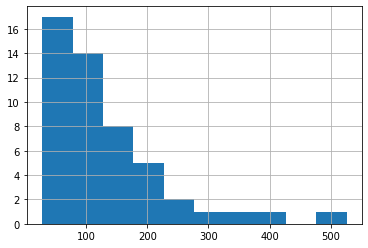

In [83]:
# Histogram of means
stocks.iloc[:,1:].mean().hist()

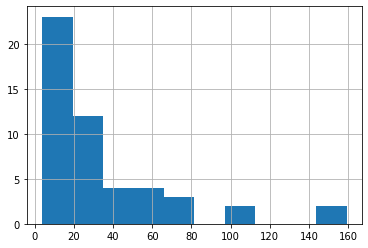

In [84]:
# Histogram of standard deviation
stocks.iloc[:,1:].std().hist()

## PreProcess Data and Train/Test Set

#### Normalize

In [0]:
stocks2 = stocks.copy(deep = True)

In [0]:
means = stocks2.loc[:,'ABT':].mean()
stocks2.loc[:,'ABT':] = stocks2.loc[:,'ABT':]/means

In [87]:
stocks2.describe()

,ABT,ABBV,ABMD,A,ALXN,ALGN,AGN,ABC,AMGN,ANTM,BAX,BDX,BIIB,BSX,BMY,CAH,CNC,CERN,CI,COO,CVS,DHR,DVA,XRAY,EW,GILD,HCA,HSIC,HOLX,HUM,IDXX,ILMN,INCY,ISRG,IQV,JNJ,LH,LLY,MCK,MDT,MRK,MTD,MYL,PKI,PRGO,PFE,DGX,REGN,RMD,STE
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.281322,0.205326,0.572711,0.257137,0.193552,0.573263,0.253446,0.108332,0.126506,0.296051,0.291251,0.213370,0.156027,0.311692,0.122885,0.223189,0.300780,0.106877,0.174486,0.262575,0.199054,0.288749,0.128500,0.147636,0.389570,0.189526,0.260004,0.093054,0.133372,0.251532,0.445291,0.293225,0.222724,0.432389,0.309944,0.125502,0.153227,0.218082,0.198559,0.130949,0.168074,0.302842,0.350064,0.249263,0.470215,0.105204,0.162301,0.177741,0.354138,0.317990
min,0.629754,0.641856,0.198769,0.572905,0.567693,0.304580,0.537768,0.775620,0.749548,0.577763,0.542530,0.650664,0.721034,0.470398,0.727759,0.609518,0.561962,0.749533,0.624546,0.537815,0.651675,0.647421,0.639256,0.586726,0.479017,0.758302,0.643207,0.697124,0.633411,0.577812,0.382248,0.533132,0.638071,0.431145,0.564097,0.735254,0.691701,0.713121,0.677325,0.750601,0.738372,0.527990,0.343698,0.606176,0.391003,0.792920,0.668345,0.676404,0.557783,0.651990
25%,0.762152,0.830942,0.551746,0.733086,0.876559,0.434251,0.782697,0.929216,0.902813,0.711138,0.728474,0.805596,0.902798,0.733351,0.904551,0.779588,0.729508,0.916781,0.849497,0.783856,0.839440,0.767449,0.905882,0.931220,0.692498,0.846858,0.791033,0.922521,0.921951,0.754035,0.524388,0.754957,0.828838,0.592613,0.732690,0.908107,0.858767,0.845865,0.863757,0.901955,0.873786,0.687004,0.789780,0.765580,0.637175,0.928181,0.841423,0.892811,0.699965,0.727544
50%,0.883458,0.937586,0.813673,1.059970,0.947032,1.003748,0.937016,0.980677,0.981373,0.942943,1.043871,0.992113,0.977826,0.960010,1.009198,1.036626,0.952496,1.012193,0.987495,1.013320,0.976825,0.901506,1.004965,1.039001,0.892597,0.933536,0.881838,1.001535,0.975330,0.995686,0.984121,0.916050,0.937473,0.938934,0.949208,1.029582,0.982593,0.904995,0.936164,0.971407,0.952929,1.081352,1.000250,0.997083,0.866207,0.975773,1.025657,0.969045,0.873292,0.904747
75%,1.237673,1.174542,1.435508,1.199204,1.073103,1.489101,1.172513,1.046408,1.076823,1.284169,1.247467,1.205126,1.079272,1.288434,1.086789,1.207291,1.238578,1.081181,1.144713,1.189451,1.203967,1.109779,1.100809,1.114227,1.245691,1.092361,1.272491,1.077320,1.085285,1.196294,1.380435,1.298750,1.165215,1.444713,1.260667,1.098626,1.141711,1.191562,1.114147,1.054006,1.137599,1.229334,1.175209,1.223027,1.063315,1.038951,1.140527,1.111914,1.213852,1.211065
max,1.698292,1.638349,2.474302,1.547377,1.561532,2.282053,1.577569,1.297532,1.378479,1.564524,1.582703,1.427020,1.583673,1.626466,1.306291,1.360265,1.628669,1.269474,1.398030,1.599890,1.418234,1.763069,1.302951,1.261368,1.904774,1.530758,1.546236,1.190018,1.344307,1.579439,1.795071,1.652569,1.665092,1.758162,1.675946,1.260215,1.338174,1.761237,1.519178,1.411158,1.403547,1.659266,1.971469,1.487727,2.182014,1.286651,1.277709,1.465304,1.993033,1.773190


In [88]:
stocks2.head()

,Date,ABT,ABBV,ABMD,A,ALXN,ALGN,AGN,ABC,AMGN,ANTM,BAX,BDX,BIIB,BSX,BMY,CAH,CNC,CERN,CI,COO,CVS,DHR,DVA,XRAY,EW,GILD,HCA,HSIC,HOLX,HUM,IDXX,ILMN,INCY,ISRG,IQV,JNJ,LH,LLY,MCK,MDT,MRK,MTD,MYL,PKI,PRGO,PFE,DGX,REGN,RMD,STE
0,2015-01-02 00:00:00,0.778095,0.876153,0.205261,0.696345,1.401953,0.326356,1.204110,1.016408,0.906271,0.618377,0.669475,0.697867,1.137930,0.470398,1.012601,1.196884,0.579038,1.028966,0.635485,0.713813,1.188841,0.677784,1.116415,0.955130,0.493945,1.188808,0.757250,0.866364,0.648908,0.594014,0.454459,0.810140,0.804515,0.498168,0.596383,0.847004,0.763516,0.757333,1.296699,0.836225,0.872108,0.574262,1.460587,0.644784,1.785011,0.871962,0.761787,1.014532,0.645123,0.685663
1,2015-01-05 00:00:00,0.778268,0.859664,0.203941,0.683297,1.368670,0.330944,1.192772,1.007756,0.895501,0.607533,0.652855,0.702159,1.120396,0.491391,0.996776,1.190046,0.577486,1.015358,0.624546,0.708302,1.177091,0.671063,1.099779,0.948509,0.494177,1.212356,0.735138,0.858576,0.642512,0.578269,0.451313,0.833297,0.809532,0.487552,0.589320,0.841089,0.770163,0.749874,1.307338,0.832735,0.885070,0.561900,1.444258,0.629575,1.766586,0.867230,0.743121,1.020246,0.643882,0.678823
2,2015-01-06 00:00:00,0.769430,0.855409,0.198769,0.672653,1.336964,0.333615,1.185709,1.013261,0.866651,0.615814,0.649385,0.700811,1.113442,0.487477,0.995075,1.177261,0.579371,1.005073,0.627018,0.698302,1.177966,0.666477,1.083878,0.936738,0.491238,1.223128,0.733909,0.853574,0.633411,0.577812,0.452762,0.822767,0.779755,0.492690,0.575800,0.836956,0.757897,0.753658,1.304334,0.828546,0.919838,0.553665,1.404341,0.623871,1.763265,0.874467,0.731965,0.981709,0.639256,0.679244
3,2015-01-07 00:00:00,0.775669,0.889982,0.205096,0.681581,1.411945,0.345926,1.232456,1.033486,0.896918,0.618870,0.652490,0.717228,1.175294,0.499219,1.008007,1.219481,0.582531,1.015674,0.641727,0.720968,1.199217,0.670510,1.093743,0.961016,0.502763,1.246050,0.747218,0.877190,0.649400,0.588779,0.461893,0.851648,0.812040,0.495391,0.582863,0.855432,0.771191,0.748361,1.343948,0.849254,0.939510,0.563878,1.454367,0.627674,1.792724,0.886434,0.741243,1.008497,0.643544,0.684716
4,2015-01-08 00:00:00,0.791612,0.899290,0.214339,0.702011,1.380916,0.356785,1.249788,1.035846,0.893687,0.648394,0.669384,0.730301,1.165346,0.519145,1.033190,1.257093,0.591513,1.037985,0.674419,0.723902,1.224719,0.680868,1.115532,0.984743,0.514945,1.281373,0.767078,0.889536,0.666865,0.614120,0.465255,0.859949,0.798516,0.505211,0.597291,0.862158,0.791954,0.766089,1.359281,0.869613,0.958419,0.571923,1.468363,0.643468,1.833645,0.904525,0.760793,0.997441,0.654377,0.702710


##### Plot the time series after normalization

In [93]:
# Initialize figure
fig = go.Figure()
# Add Traces
# Plot all company
for i in range(noc):
    fig.add_trace(go.Scatter(x=stocks2.Date,
                             y=stocks2[company_names[i]],
                             name=company_names[i]))
#set company buttons
fig.update_layout(updatemenus=[dict(active=0,
                                    buttons=buttons
                                    )
                              ]
                  )
#set range
fig.update_xaxes(rangeslider_visible=True,
                 rangeselector=dict(buttons=rangebuttons)
                )
# Set title
fig.update_layout(title_text="Stock prices after normalization")

fig.show()

#### Series to Supervised

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""#n_vars = 1 if type(data) is list else data.shape[1]
  variables = list(data.columns)
  df = data.copy(deep = True)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += ['{}(t-{})'.format(j, i) for j in variables]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += ['{}(t)'.format(j) for j in variables]
    else:
      names += ['{}(t+{})'.format(j, i) for j in variables]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [0]:
df = series_to_supervised(stocks2.loc[:,'ABT':], n_in=4, n_out=2, dropnan=False)

In [0]:
print('new shape is {}'.format(df.shape))
#shape is 350 because it is all 50 stocks of t+1. Remove all except ABT
columns = list(df.columns)[-49:]

new shape is (1337, 300)


In [0]:
df.drop(columns = list(df.columns)[-49:], inplace = True)

In [0]:
print('new shape is {}.'.format(df.shape))

new shape is (1337, 251).


In [0]:
#Look at the y values
df.iloc[0:5,[0, 50, 100, 150, 200, 250]]

,ABT(t-4),ABT(t-3),ABT(t-2),ABT(t-1),ABT(t),ABT(t+1)
0,NaN,NaN,NaN,NaN,0.778095,0.778268
1,NaN,NaN,NaN,0.778095,0.778268,0.769430
2,NaN,NaN,0.778095,0.778268,0.769430,0.775669
3,NaN,0.778095,0.778268,0.769430,0.775669,0.791612
4,0.778095,0.778268,0.769430,0.775669,0.791612,0.783294


In [0]:
df.iloc[-5:, [0, 50, 100, 150, 200, 250]]

,ABT(t-4),ABT(t-3),ABT(t-2),ABT(t-1),ABT(t),ABT(t+1)
1332,1.544752,1.575945,1.663633,1.663806,1.698292,1.629840
1333,1.575945,1.663633,1.663806,1.698292,1.629840,1.654621
1334,1.663633,1.663806,1.698292,1.629840,1.654621,1.627934
1335,1.663806,1.698292,1.629840,1.654621,1.627934,1.630013
1336,1.698292,1.629840,1.654621,1.627934,1.630013,NaN


In [0]:
#Save the last day as a forecast of 1 day ahead of last day
last_day = df.iloc[1336,0:250]
last_day

ABT(t-4)     1.698292
ABBV(t-4)    1.116832
ABMD(t-4)    0.914350
A(t-4)       1.328310
ALXN(t-4)    0.801803
               ...   
PFE(t)       1.040342
DGX(t)       1.177639
REGN(t)      1.400523
RMD(t)       1.816772
STE(t)       1.555475
Name: 1336, Length: 250, dtype: float64

Since we are shifting the data, we will have to remove the rows with Nan's in them. Should reduce the rows by 5.

#### Data set of (N-5) 'cases' for prediction task

This is another way of saying remove all of the NaN values from shifting the data

In [0]:
df.dropna(inplace = True)
shape = df.shape
shape

(1332, 251)

Split into train and test set

In [0]:
#split into PredTest and PredTrain
train = df.sample(frac=0.9, random_state = 9)
train_idx = list(train.index)
train.shape

(1199, 251)

In [0]:
test = df.drop(index = train_idx)
test.shape

(133, 251)

In [0]:
trainX, trainy = train.iloc[:,:250], train.iloc[:,250]
testX, testy = test.iloc[:,:250], test.iloc[:,250]

print('TrainX: {}\tTrainy = {}'.format(trainX.shape, trainy.shape))
print('TestX: {}\tTest = {}'.format(testX.shape, testy.shape))

TrainX: (1199, 250)	Trainy = (1199,)
TestX: (133, 250)	Test = (133,)


In [0]:
trainy.head()

615    0.825578
943    1.279091
415    0.744822
832    1.016376
63     0.800450
Name: ABT(t+1), dtype: float64

## AutoEncoder

#### Plausable dimension h for H

In [0]:
corr = df.iloc[:,:250].corr()
corr.describe()

,ABT(t-4),ABBV(t-4),ABMD(t-4),A(t-4),ALXN(t-4),ALGN(t-4),AGN(t-4),ABC(t-4),AMGN(t-4),ANTM(t-4),BAX(t-4),BDX(t-4),BIIB(t-4),BSX(t-4),BMY(t-4),CAH(t-4),CNC(t-4),CERN(t-4),CI(t-4),COO(t-4),CVS(t-4),DHR(t-4),DVA(t-4),XRAY(t-4),EW(t-4),GILD(t-4),HCA(t-4),HSIC(t-4),HOLX(t-4),HUM(t-4),IDXX(t-4),ILMN(t-4),INCY(t-4),ISRG(t-4),IQV(t-4),JNJ(t-4),LH(t-4),LLY(t-4),MCK(t-4),MDT(t-4),...,BAX(t),BDX(t),BIIB(t),BSX(t),BMY(t),CAH(t),CNC(t),CERN(t),CI(t),COO(t),CVS(t),DHR(t),DVA(t),XRAY(t),EW(t),GILD(t),HCA(t),HSIC(t),HOLX(t),HUM(t),IDXX(t),ILMN(t),INCY(t),ISRG(t),IQV(t),JNJ(t),LH(t),LLY(t),MCK(t),MDT(t),MRK(t),MTD(t),MYL(t),PKI(t),PRGO(t),PFE(t),DGX(t),REGN(t),RMD(t),STE(t)
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.409352,0.304824,0.280925,0.400718,-0.212445,0.361882,-0.271019,-0.033358,0.411180,0.410620,0.396288,0.398539,0.000010,0.397150,-0.118557,-0.330166,0.389338,0.250060,0.353988,0.410984,-0.285375,0.385765,-0.046576,-0.156202,0.378950,-0.227616,0.396475,0.113753,0.340062,0.403595,0.390685,0.396690,-0.123744,0.403432,0.405912,0.350690,0.370051,0.364421,-0.198448,0.382552,...,0.395746,0.397702,0.000218,0.395452,-0.118423,-0.328793,0.389425,0.252287,0.354525,0.410910,-0.284863,0.385268,-0.042396,-0.162450,0.378210,-0.223441,0.396893,0.105239,0.342082,0.403825,0.389270,0.395203,-0.127984,0.402667,0.406520,0.350472,0.370674,0.366448,-0.196248,0.380382,0.356409,0.384014,-0.267671,0.412626,-0.253604,0.327250,0.316232,-0.130032,0.398860,0.397619
std,0.633901,0.477851,0.568669,0.675032,0.585277,0.625850,0.664793,0.436169,0.564862,0.656867,0.693806,0.697181,0.339960,0.693371,0.465989,0.692449,0.610213,0.180612,0.512528,0.660486,0.667492,0.659408,0.421440,0.347759,0.661848,0.632226,0.617585,0.276151,0.528860,0.633943,0.697084,0.595683,0.351394,0.697369,0.670141,0.635411,0.589585,0.578644,0.619310,0.573282,...,0.694120,0.697185,0.334872,0.693694,0.464901,0.693140,0.609188,0.183116,0.510941,0.662392,0.667451,0.659977,0.415087,0.350791,0.662531,0.630524,0.617614,0.271318,0.529515,0.632957,0.697887,0.596369,0.352447,0.697515,0.671106,0.634828,0.588288,0.577415,0.616818,0.574861,0.599998,0.673649,0.645548,0.674100,0.659253,0.514621,0.556641,0.472706,0.636920,0.652048
min,-0.858191,-0.673202,-0.774373,-0.862602,-0.771567,-0.840306,-0.861867,-0.518884,-0.709205,-0.883036,-0.912157,-0.910382,-0.444877,-0.900377,-0.576886,-0.930026,-0.824212,-0.139090,-0.645721,-0.861580,-0.887012,-0.852384,-0.489633,-0.626033,-0.856634,-0.814018,-0.814381,-0.452482,-0.693680,-0.833034,-0.912831,-0.830279,-0.496740,-0.930038,-0.891297,-0.855647,-0.733462,-0.775940,-0.755640,-0.715224,...,-0.912012,-0.911804,-0.415089,-0.902641,-0.569862,-0.930038,-0.820291,-0.151097,-0.643957,-0.863312,-0.885297,-0.856514,-0.469514,-0.628180,-0.856418,-0.806673,-0.816371,-0.444877,-0.682864,-0.830383,-0.915727,-0.834558,-0.506628,-0.930026,-0.894693,-0.860102,-0.734992,-0.776519,-0.749235,-0.715382,-0.768914,-0.884081,-0.856634,-0.889983,-0.855289,-0.692806,-0.768245,-0.579132,-0.836906,-0.877723
25%,-0.289320,-0.125451,-0.382874,-0.299796,-0.660988,-0.350312,-0.766733,-0.351151,-0.180406,-0.347380,-0.367447,-0.394683,-0.259185,-0.371145,-0.474096,-0.8

In [0]:
eigs, eig_vals = np.linalg.eig(corr)

In [0]:
ratio = np.cumsum(eigs)/np.sum(eigs)
print('min: {}\t max: {}'.format(min(ratio),max(ratio)))

min: 0.66482497373392	 max: 0.9999999999999997


Plot the Ratio

In [0]:
ratio[ratio>.90]

array([0.90630778, 0.92590138, 0.93858037, 0.94976239, 0.95746921,
       0.96241688, 0.9668171 , 0.96997712, 0.97303062, 0.97579463,
       0.97804881, 0.98018489, 0.98197296, 0.9835886 , 0.9848806 ,
       0.98607476, 0.98699751, 0.98785036, 0.98860041, 0.98926232,
       0.98989752, 0.99049247, 0.99100282, 0.99147996, 0.99193627,
       0.9923381 , 0.99271241, 0.99305894, 0.99337659, 0.99366856,
       0.99395995, 0.99423   , 0.99449546, 0.99473849, 0.99496296,
       0.99518133, 0.99537791, 0.99555904, 0.99572324, 0.995882  ,
       0.99602886, 0.99616734, 0.99630323, 0.99643266, 0.99655539,
       0.99666183, 0.99676718, 0.99686825, 0.99696485, 0.99705503,
       0.99714308, 0.99722981, 0.99730904, 0.997384  , 0.99745651,
       0.9975252 , 0.99759098, 0.99765436, 0.99771574, 0.99777336,
       0.99782956, 0.99788052, 0.9979341 , 0.99798686, 0.99803448,
       0.99808054, 0.99812513, 0.99816816, 0.99820986, 0.99825016,
       0.9982898 , 0.99832836, 0.99836638, 0.99840369, 0.99843

In [0]:
h = np.min(np.nonzero(ratio>.90))
h

5

In [0]:
#Hidden Layer of size 5??
ratio[h]

0.9063077771299585

According to this we can get a hidden layer of size 5 with 90.6 of the variance explained. Which means our dim(H) = 5

#### AutoEncoder to compress the input vectors Xt